**Title: Linear Kalman Filter for 2D motion**<br><br>
**Description:** This code implements a linear Kalman filter for a 2D object moving with constant velocity. In this implementation, the state of the object is represented by a 4D vector, containing the position and velocity in both the x and y directions. The Kalman filter predicts the next state of the object based on the previous state and a state transition model, and updates the state estimate based on noisy measurements of the object's position. The Kalman filter uses a covariance matrix to model the uncertainty in the state estimate, and iteratively updates this matrix based on the prediction and measurement steps.<br><br>
**Author:** Akshay Laxman Powar<br>
**Date:** 20.02.2023<br>

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt


# offsets of each variable in the mean state matrix
num_states = 4
measu_inputs = 2
control_inputs = 2
rad_wheel =  0.055
state_Dx, state_Dy, state_Vx, state_Vy = 0,1,2,3

class KF:
    """
    Implementation of the Linear Kalman filter.
    """
    def __init__(self, initial_state, 
                       initial_covariance,
                       measurement,
                       control_input,
                       process_noise,
                       measurement_noise) -> None:
        
        """
        Initializes the mean state and covariance matrix of the state Gaussian random variable (GRV).
        
        Args:
            initial_x (list): The initial position of the system as a list of [x, y] coordinates.
            initial_v (list): The initial velocity of the system as a list of [vx, vy] coordinates.
            accel_variance (float): The variance of the acceleration noise.
        """
        
        # mean state matrix of Gaussian Random Variable (GRV)
        # initialized as 4x1 matrix [posX, posY, velX, velY]
        self._x = initial_state.reshape(num_states,1)
        # covariance of state Gaussian Random Variable (GRV)
        # initialized as 4x4 identity matrix
        self._P = initial_covariance
        # control input matrix
        # initialized as 2x1 matrix [accX, accY]
        self._u = control_input
        # process noise matrix
        # initialized as 4x4 matrix diag([sigma(posX)2, sigma(posY)2, sigma(velX)2, sigma(velY)2])
        self._Q = process_noise
        # measurement noise matrix
        # initialized as 6x6 matrix diag([sigma(posX1)2, sigma(posY1)2)
        self._R = measurement_noise
        # measurement matrix
        # initialized as 2x1 empty matrix
        self._z = measurement  
        

    def predict(self, dt: float) -> None:
        """
        Predict the state of the object after a time interval of dt seconds.
        
        Parameters
        ----------
        dt : float
            The time interval in seconds.
            
        Returns
        -------
        None
        
        
        Equations related to prediction Step
        x = F x
        P = F P Ft + G a Gt
        """
        
        # 4x4 state transition matrix
        F = np.eye(num_states) 
        F[state_Dx,state_Vx] = dt     
        F[state_Dy,state_Vy] = dt
        '''
        F = array([[1., 0., 1., 0.],
                   [0., 1., 0., 1.],
                   [0., 0., 1., 0.],
                   [0., 0., 0., 1.]])
        '''
        B = np.zeros((num_states, control_inputs))
        B[state_Dx,state_Dx] = B[state_Dy,state_Dy] = dt**2/2
        B[state_Vx,state_Dx] = B[state_Vy,state_Dy] = dt
        
        # 4x1 mean state matrix at time t
        # x = F x --> new state as per the state transition matrix
        predicted_x = F.dot(self._x) + B.dot(self._u)

        # 4x4 state covariance matrix at time t
        predicted_P = F.dot(self._P).dot(F.T) + self._Q

        self._P = predicted_P
        self._x = predicted_x

    def update(self, meas_value):
        """
        Update the state of the object after a time interval of dt seconds when measurements are received.
        
        Parameters
        ----------
        meas_value : array
            The actual measurement at a given time.
        meas_variance : array 
            The covariance matrix of the measurement noise.
        
        Returns
        -------
        None
        
        Equations related to update Step
        y = z - H x
        S = H P Ht + R
        K = P Ht S^-1
        x = x + K y
        P = (I - K H) * P
        """
        
        # 2x4 state observation matrix 
        H = np.concatenate((np.eye(measu_inputs),np.zeros((num_states-measu_inputs,num_states - measu_inputs))),axis=1)

        # 2x1 measurement matrix at time t ([[mDx],[mDy]])
        self._z = meas_value 

        # 4x1 innovation i.e (difference between the actual measurement z and the predicted measurement Hx)
        y = self._z - H.dot(self._x)
        
        # 2x2 innovation covariance matrix (a measure of the error between the predicted measurement and the actual measurement)
        S = H.dot(self._P).dot(H.T) + self._R
        
        # 4x1 Kalman Gain Matrix 
        K = self._P.dot(H.T).dot(np.linalg.inv(S))

        # 4x1 updated state matrix after measurement at time t
        updated_x = self._x + K.dot(y)
        
        # 4x4 updated state covariance matrix after measurement at time t
        updated_P = (np.eye(4) - K.dot(H)).dot(self._P)

        self._x = updated_x
        self._P = updated_P
        

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x

    @property
    def pos(self) -> float:
        return (self._x[0]**2 + self._x[1]**2)**(1/2)

    @property
    def vel(self) -> float:
        return (self._x[2]**2 + self._x[3]**2)**(1/2)
    


In [2]:
def kalman_filter_localization(measurement_rate:int):
    
    plt.ion()
    #plt.figure(figsize=(15,9))
    #######################----------Initialization for filter--------------############################
    init_state = np.array([20, 50, 1, 1]).reshape(num_states,1)
    init_cov = np.eye(num_states)
    u = np.array([0.01, 
                  0.01]).reshape(2,1)
    process_variance = np.array([[1.5,  0,  0,     0],
                                  [0,  1.5,  0,     0],
                                  [0,    0,  0.15, 0],
                                  [0,    0,    0,     0.15]])
    
    measu_variance = 0.01
    Q = np.eye(num_states).dot(process_variance)       
    R = np.eye(measu_inputs).dot(measu_variance)
    z = np.array([0,0]).reshape(measu_inputs,1)    
        
    
    # initialize the class EKF with constructor parameters
    kf = KF(init_state, init_cov, z, u, Q, R)
    
    # minimum time step (dt) used in the simulation
    time_step = 1
    # total number of time steps for which simulation will run
    total_time_steps = 120
    # time step at which measurement is received
    measurement_rate = 5
    
    
    true_mean_vehicle = np.zeros(( num_states, 1, total_time_steps))
    true_control_input = np.zeros(( control_inputs, 1, total_time_steps))
    # defining the initial true mean state of a system at time t=0
    true_mean_vehicle[:,:,0] = np.array([20, 50, 1, 1]).reshape(num_states,1)
    true_control_input[:,:,0] = np.array([0.01, 0.01]).reshape(control_inputs,1)
    
    
    mean_state_estimate_1 = np.zeros((num_states, 1, total_time_steps))
    mean_after_prediction = np.zeros((num_states, 1, total_time_steps))
    mean_after_gps_update = np.zeros((num_states, 1, total_time_steps))
    updatesteps= []
    mean_state_after_gps1_update = np.zeros(( num_states, 1, total_time_steps))
    mean_state_after_gps1_update[:,:,0] = np.array([20, 50, 1, 1]).reshape(num_states,1)
    mean_state_after_gps2_update = np.zeros(( num_states, 1, total_time_steps))
    mean_state_after_gps2_update[:,:,0] = np.array([20, 50, 1, 1]).reshape(num_states,1)
    mean_state_after_gps3_update = np.zeros(( num_states, 1, total_time_steps))
    mean_state_after_gps3_update[:,:,0] = np.array([20, 50, 1, 1]).reshape(num_states,1)
    mean_state_after_prediction = np.zeros(( num_states, 1, total_time_steps))
    mean_state_after_prediction[:,:,0] = np.array([20, 50, 1, 1]).reshape(num_states,1)

    for step in range(total_time_steps):

        if step>0:   
            if step>50 and step<60:
                true_control_input[0,:,step] = 0.97*(true_control_input[0,:,step-1])
            else:
                true_control_input[0,:,step] = true_control_input[0,:,step-1]
    
            if step > 0 and step < 20:
                true_control_input[1,:,step] = (true_control_input[1,:,step-1])-0.001
            else:
                true_control_input[1,:,step] = true_control_input[1,:,step-1]
                
            F = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]])    
            true_mean_vehicle[:,:,step] = F.dot(true_mean_vehicle[:,:,step-1]) + np.array([[time_step**2/2, 0],
                                                                                              [0, time_step**2/2],
                                                                                              [time_step, 0],
                                                                                              [0, time_step]]).dot(true_control_input[:,:,step])
            
            kf.predict(dt=time_step)
    
            '''
            True mean position of the vehicle after minimum simulation time step. To calculate this 
            input velocity times the minimum time step is added to the previous true mean state.
            ---------------
            new position = old position + input velocity * simulation time step
            this is equivalent to 
            i = i + 2
            ---------------
            To simulate real-world conditions, random Gaussian noise is added to this position 
            to generate artificial position. This generated position is treated as sensor measurements.
            '''
            
            mean_state_after_prediction[:,:,step] = kf.mean
    
            if step != 0 and step % measurement_rate == 0:
                ''' Update by adding the random Gaussian noise into the true mean position'''
                updatesteps.append(step)
    
    
                kf.update(meas_value=((true_mean_vehicle[0:2,:,step] + np.array([[-1],[0]]) + 1 * np.random.randn() * np.sqrt(measu_variance))-np.array([[-1],[0]])))
                mean_state_after_gps1_update[:,:,step] = kf.mean
    
    
                kf.update(meas_value=((true_mean_vehicle[0:2,:,step] + np.array([[+0.5],[0.8660]]) + 1 * np.random.randn() * np.sqrt(measu_variance))-np.array([[+0.5],[0.8660]])))
                mean_state_after_gps2_update[:,:,step] = kf.mean
    
    
                kf.update(meas_value=(true_mean_vehicle[0:2,:,step] + np.array([[0.5],[-0.8660]]) + 1 * np.random.randn() * np.sqrt(measu_variance)-np.array([[0.5],[-0.8660]])))
                mean_state_after_gps3_update[:,:,step] = kf.mean
                
            
        mean_state_estimate_1[:,:,step] = kf.mean

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('Position X-Y GPS')
    ax1.plot(mean_state_estimate_1[0,0,:], mean_state_estimate_1[1,0,:], 'k')  # ms[0] has x position estimates
    ax1.plot(true_mean_vehicle[0,0,:], true_mean_vehicle[1,0,:], 'm--')  # true_mean_vehicle has x and y coordinates

    ax2.set_title('Velocity X-Y GPS')
    ax2.plot(mean_state_estimate_1[2,0,:], mean_state_estimate_1[3,0,:], 'k')  # mean_state_estimate_1 has x and y velocity estimates
    ax2.plot(true_mean_vehicle[2,0,:], true_mean_vehicle[3,0,:], 'm--')  # true_mean_vehicle has x and y velocities
    
    plt.tight_layout()
    #plt.show()

    
    mse_pred = np.square(
                    np.subtract(np.sqrt(np.square(true_mean_vehicle[0,:,updatesteps])+ np.square(true_mean_vehicle[1,:,updatesteps])), 
                                np.sqrt(np.square(mean_state_after_prediction[0,:,updatesteps])+ np.square(mean_state_after_prediction[1,:,updatesteps]))
                    )).mean()

    rmse_pred = np.sqrt(mse_pred)
    
    mse_est_using_gps1 = np.square(
                    np.subtract(np.sqrt(np.square(true_mean_vehicle[0,:,updatesteps])+ np.square(true_mean_vehicle[1,:,updatesteps])), 
                                np.sqrt(np.square(mean_state_after_gps1_update[0,:,updatesteps])+ np.square(mean_state_after_gps1_update[1,:,updatesteps]))
                    )).mean()
    rmse_est_using_gps1 = np.sqrt(mse_est_using_gps1)
    
    mse_est_using_gps2 = np.square(
                    np.subtract(np.sqrt(np.square(true_mean_vehicle[0,:,updatesteps])+ np.square(true_mean_vehicle[1,:,updatesteps])), 
                                np.sqrt(np.square(mean_state_after_gps2_update[0,:,updatesteps])+ np.square(mean_state_after_gps2_update[1,:,updatesteps]))
                    )).mean()
    rmse_est_using_gps2 = np.sqrt(mse_est_using_gps2)
    
    mse_est_using_gps3 = np.square(
                    np.subtract(np.sqrt(np.square(true_mean_vehicle[0,:,updatesteps])+ np.square(true_mean_vehicle[1,:,updatesteps])), 
                                np.sqrt(np.square(mean_state_after_gps3_update[0,:,updatesteps])+ np.square(mean_state_after_gps3_update[1,:,updatesteps]))
                    )).mean()
    rmse_est_using_gps3 = np.sqrt(mse_est_using_gps3)
    
    mse = np.square(
                    np.subtract(np.sqrt(np.square(true_mean_vehicle[0,:,updatesteps])+ np.square(true_mean_vehicle[1,:,updatesteps])), 
                                np.sqrt(np.square(mean_state_estimate_1[0,:,updatesteps])+ np.square(mean_state_estimate_1[1,:,updatesteps]))
                    )).mean()
    rmse = np.sqrt(mse)
    
    return np.array([rmse_pred, rmse_est_using_gps1, rmse_est_using_gps2, rmse_est_using_gps3, rmse])


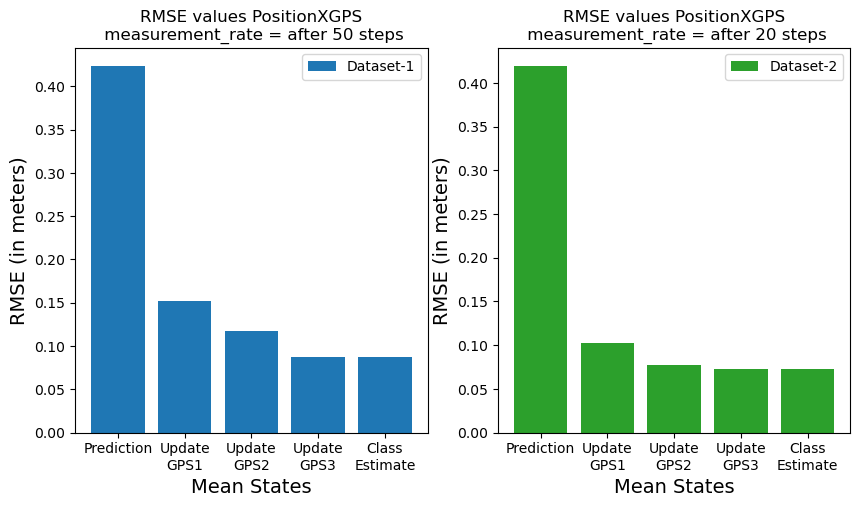

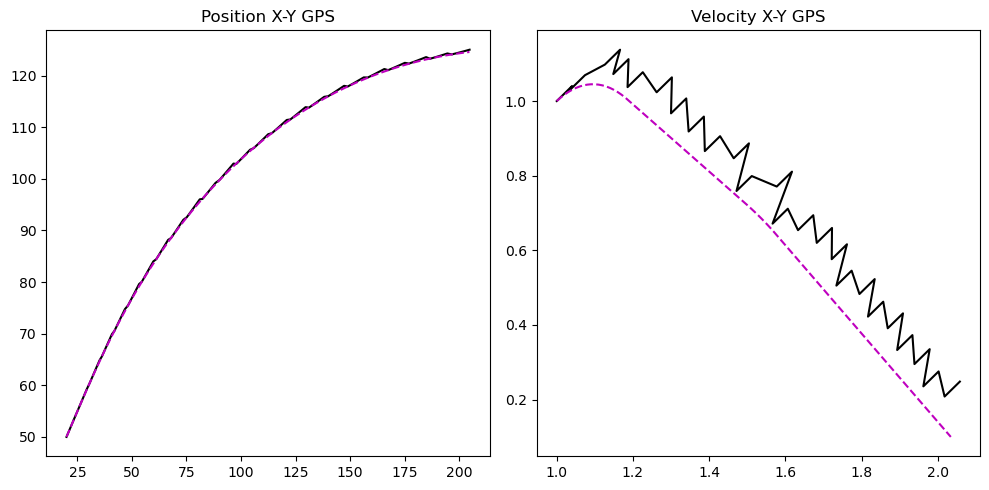

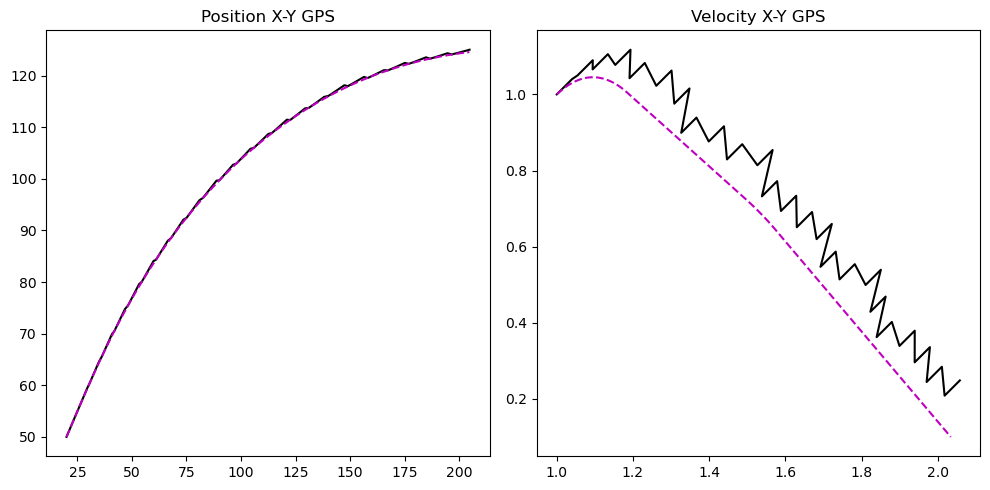

In [3]:
plt.ion()
# Create a figure with two subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a list of sensor names and RMSE values
labels = ['Prediction','Update\nGPS1', 'Update\nGPS2', 'Update\nGPS3', 'Class\nEstimate']
rmse_values_50 = kalman_filter_localization(50)
rmse_values_20 = kalman_filter_localization(20)

# Plot the RMSE values
ax1.bar(labels, rmse_values_50, capsize=5, color='tab:blue', label = 'Dataset-1')
ax1.set_title('RMSE values PositionXGPS\n measurement_rate = after 50 steps')
ax1.set_xlabel('Mean States', fontsize=14)
ax1.set_ylabel('RMSE (in meters)', fontsize=14)
ax1.legend(loc = 'upper right')

ax2.bar(labels, rmse_values_20, capsize=5, color='tab:green', label = 'Dataset-2')
ax2.set_title('RMSE values PositionXGPS\n measurement_rate = after 20 steps')
ax2.set_xlabel('Mean States', fontsize=14)
ax2.set_ylabel('RMSE (in meters)', fontsize=14)
ax2.legend(loc = 'upper right')

#plt.tight_layout()
#fig.savefig('bar_plot_rmse_50_20.png')
plt.show()